*Автор: Татьяна Рогович*

# Анализ данных в Python

## Bag of Words (мешок слов), стемминг и классификация текстов

*Автор: Татьяна Рогович, НИУ ВШЭ*


In [1]:
import pandas as pd

### Что такое NLP?
Обработка естественного языка - (Natural Language Processing, NLP ), представляет собой набор методов для решения задач по обработке текстов. В этом уроке, мы попробуем загрузить и почистить текст новостей, а затем, использую простую модель признаков - мешка слов (Bag of Words), научимся довольно точно предсказывать фэйковая это новость или настоящая.

Но для начала посмотрим как работает bag of words на игрушечном примере.

### Создаем признаки (features) из Bag of Words

Как превратить текст в некоторое численное представление для машинного обучения? Один из таких подходов называется мешком слов (Bag of Words). Модель Bag of Words изучает все слова, которые есть в нашем корпусе, а затем моделирует каждый документ, подсчитывая количество раз, когда появляется каждое слово. Например, рассмотрим следующие два предложения:

Предложение 1: "The cat sat on the hat"

Предложение 2: "The dog ate the cat and the hat"

Для этих двух сообщений,получим следующий словарь:

{ the, cat, sat, on, hat, dog, ate, and }

Чтобы получить наш мешок слов, мы подсчитаем сколько раз каждое слово появилось в предложении. В предложение 1, "the" появилось два раза, а "cat", "sat", "on", и "hat" по одному разу каждый. Поэтому вектор признаков для этого предложения выглядит так:

{ the, cat, sat, on, hat, dog, ate, and }

{ 2, 1, 1, 1, 1, 0, 0, 0 }

Аналогично, признаки предложения 2 будут такими: 

{ 3, 1, 0, 0, 1, 1, 1, 1}

## Как перевести текст в признаки?

Если наша задача типовая, то скорее всего в sklearn уже есть библиотека, с помощью которой можно ее решить. Мы будем пользоваться классом CountVectorizer(), который при обучении создает признаки из всех слов обучающей выборки, при трансформации - подсчитывает встречание этих слов в тренировочной и тестовой выборке. А потом получившиеся наборы данных мы уже передаем алгоритмам для предсказания.

In [2]:
# создадим тренировочный список текстов
simple_train = ['call you tonight', 'Call me a cab', 'call 222-22-22', 'please call me.. please']

In [3]:
# Импортируем и иниициализируем класс CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [4]:
# обучаемся на данных
vect.fit(simple_train)

CountVectorizer()

In [5]:
# Смотрим сгенерированные признаки
vect.get_feature_names()


['22', '222', 'cab', 'call', 'me', 'please', 'tonight', 'you']

Обратите внимание, что в наш векторайзер уже зашита базовая обработка текста. Он приводит текст к нижнему регистру, и с помощью регулярок забирает только слова, состоящие из цифр и букв (знаки препинания удаляются), удаляет стоп-слова.

Метод fit здесь разбивает текст на токены и сохраняет их в "модель". Метод transform мы используем, чтобы создать разреженную матрицу, в которой мы будем хранить информацию, сколько каждое слово встречалось в каждом "тексте".

In [6]:
# преобразовываем исходный текст в матрицу признаков
simple_train_matrix = vect.transform(simple_train)
# каждый ряд - одно наблюдение (наш документ), каждая колонка - один признак (слово). 
# На пересечении - количество слов в документе.
simple_train_matrix

<4x8 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>

In [7]:
simple_train_matrix.toarray()

array([[0, 0, 0, 1, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 0, 0, 0],
       [2, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 2, 0, 0]])

*sparse matrix*

Разреженная матрица. Хранит только координаты ненулевых значений. Сильно экономит место. 

*dense matrix*

Плотная матрица. Хранит все данные.
Если у вас матрица 1000 на 1000 из нулей - она все это хранит (1 мб ничего).

In [8]:
pd.DataFrame(simple_train_matrix.toarray(), columns=vect.get_feature_names(), index=simple_train)

,22,222,cab,call,me,please,tonight,you
call you tonight,0,0,0,1,0,0,1,1
Call me a cab,0,0,1,1,1,0,0,0
call 222-22-22,2,1,0,1,0,0,0,0
please call me.. please,0,0,0,1,1,2,0,0


In [9]:
print('sparse matrix')
print(simple_train_matrix)

print('dense matrix')
print(simple_train_matrix.toarray())

sparse matrix
  (0, 3)	1
  (0, 6)	1
  (0, 7)	1
  (1, 2)	1
  (1, 3)	1
  (1, 4)	1
  (2, 0)	2
  (2, 1)	1
  (2, 3)	1
  (3, 3)	1
  (3, 4)	1
  (3, 5)	2
dense matrix
[[0 0 0 1 0 0 1 1]
 [0 0 1 1 1 0 0 0]
 [2 1 0 1 0 0 0 0]
 [0 0 0 1 1 2 0 0]]


In [10]:
# создадим текст для теста и преобразуем обученным CountVectorizer
simple_test = ['Please don\'t call me, I will be busy']
simple_test_matrix = vect.transform(simple_test)
simple_test_matrix.toarray()

array([[0, 0, 0, 1, 1, 1, 0, 0]])

In [11]:
# куда делся don't?
pd.DataFrame(simple_test_matrix.toarray(), columns=vect.get_feature_names(), index=simple_test)

,22,222,cab,call,me,please,tonight,you
"Please don't call me, I will be busy",0,0,0,1,1,1,0,0


Transform для тестовой выборки будет игнорировать токены, которые он не видел раньше (поэтому важен большой размер обучающей выборки и ее репрезентативность корпуса текстов).

### Стемминг (Stemming) и Лемматизация (Lemmatization)

Процесс стемминга заключается в преобразовании различных вариантов одного и того же слова в одну ядерную форму. Например у нас есть слова "running", "runs" и "run", которые семантически говорят об одном и том же, поэтому мы можем вместо них использовать одно слово "run". Стоит отметить, что в этом случае мы можем потерять некоторые грамматические признаки, например форму времени.

Воспользуемся алгоритмом Портера из модуля NLTK. Посмотрим на работу алгоритма на примере с вариантами слов run

In [12]:
!pip install nltk

In [13]:
import nltk

In [14]:
stemmer = nltk.stem.PorterStemmer()

print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


С русским языком не работает, к сожалению. Но сам Портер адаптировал алгоритм позже для ряда языков (смотри ниже Snowball stemming).

In [15]:
print("The stemmed form of бегать is: {}".format(stemmer.stem("бегать")))

The stemmed form of бегать is: бегать


Мы успешно обрезали наши слова до базовой формы. Алгоритм не использует баз основ слов, а лишь, применяя последовательно ряд правил, отсекает окончания и суффиксы, основываясь на особенностях языка, в связи с чем работает быстро, но не всегда безошибочно.

Однако у стемминга есть тенденция к "грубому" обрезанию концов слов. Например, для leaves мы получим следующее:

In [16]:
print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))

The stemmed form of leaves is: leav


С одной стороны это нормально, но базовой формой слова будет leaf. Поэтому на помощь нам приходит лемматизация.

Лемматизация пытается достигнуть того же эффекта, но в отличие от стеммера, лемматизация использует реальный словарь слов и поэтому не будет обрубать окончания слов, а будет возвращать лемму.

Снова воспользуемся модулем NLTK и проверим, что он нам выдаст на leaves:

In [17]:
# Импортируем
from nltk.stem import WordNetLemmatizer
# Инициализируем 
lemm = WordNetLemmatizer()

print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))

The lemmatized form of leaves is: leaf


Получили верный ответ. Лемматизация обеспечивает нам более тонкую настройку по сравнению со стеммингом. Но чтобы интегрировать лемматизацию в count vectorizer, очистку текста придется делать сначала вручную (см. ниже).

## Работа с русскоязычными текстами

С поддержкой русского языка у nltk не супер, к сожалению. Можно воспользоваться алгоритмом для стемминга, который является адаптацией стеммера Портера (но с русским языком ему сильно тяжелее, чем с английским).

In [18]:
from nltk.stem.snowball import RussianStemmer

rus_stemmer = RussianStemmer()

print(rus_stemmer.stem('бежать'))
print(rus_stemmer.stem('бегущий'))
print(rus_stemmer.stem('бегающий'))

бежа
бегущ
бега


Если библиотека pymorphy, которая делает лемматизацию, основываясь на словаре проекта OpenCorpora. https://pymorphy2.readthedocs.io/

Далее объяснения и примеры из документации.

В pymorphy2 для морфологического анализа слов (русских) есть класс MorphAnalyzer.
Экземпляры класса MorphAnalyzer занимают порядка 10-15Мб оперативной памяти (т.к. загружают в память словари, данные для предсказателя и т.д.); старайтесь ораганизовать свой код так, чтоб создавать экземпляр MorphAnalyzer заранее и работать с этим единственным экземпляром в дальнейшем.

Метод MorphAnalyzer.parse() принимает слово (обязательно в нижнем регистре) и возвращает все возможные разборы слова:

In [19]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
morph.parse('стали')

[Parse(word='стали', tag=OpencorporaTag('VERB,perf,intr plur,past,indc'), normal_form='стать', score=0.975342, methods_stack=((DictionaryAnalyzer(), 'стали', 945, 4),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn sing,gent'), normal_form='сталь', score=0.010958, methods_stack=((DictionaryAnalyzer(), 'стали', 13, 1),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn plur,nomn'), normal_form='сталь', score=0.005479, methods_stack=((DictionaryAnalyzer(), 'стали', 13, 6),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn sing,datv'), normal_form='сталь', score=0.002739, methods_stack=((DictionaryAnalyzer(), 'стали', 13, 2),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn sing,loct'), normal_form='сталь', score=0.002739, methods_stack=((DictionaryAnalyzer(), 'стали', 13, 5),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn plur,accs'), normal_form='сталь', score=0.002739, methods_stack=((DictionaryAnalyzer(), 'стали', 13, 9),))]

Обратите внимание, что в этом примере слово “стали” может быть разобрано и как глагол (“они стали лучше справляться”), и как существительное (“кислородно-конверторный способ получения стали”). На основе одной лишь информации о том, как слово пишется, понять, какой разбор правильный, нельзя, поэтому анализатор может возвращать несколько вариантов разбора.

**Выбор правильного разбора**  
pymorphy2 возвращает все допустимые варианты разбора, но на практике обычно нужен только один вариант, правильный.

У каждого разбора есть параметр score. Score - это оценка P(tag|word), оценка вероятности того, что данный разбор правильный.

pymorphy2 умеет разбирать не только словарные слова; для несловарных слов автоматически задействуется предсказатель. Например, попробуем разобрать слово “бутявковедами” - pymorphy2 поймет, что это форма творительного падежа множественного числа существительного “бутявковед”, и что “бутявковед” - одушевленный и мужского рода:

In [20]:
morph.parse('бутявковедами')

[Parse(word='бутявковедами', tag=OpencorporaTag('NOUN,anim,masc plur,ablt'), normal_form='бутявковед', score=0.9821428571428571, methods_stack=((FakeDictionary(), 'бутявковедами', 52, 10), (KnownSuffixAnalyzer(min_word_length=4, score_multiplier=0.5), 'едами'))),
 Parse(word='бутявковёдами', tag=OpencorporaTag('NOUN,anim,masc,Name plur,ablt'), normal_form='бутявковёд', score=0.008928571428571428, methods_stack=((FakeDictionary(), 'бутявковёдами', 27, 10), (KnownSuffixAnalyzer(min_word_length=4, score_multiplier=0.5), 'ёдами'))),
 Parse(word='бутявковёдами', tag=OpencorporaTag('NOUN,inan,masc plur,ablt'), normal_form='бутявковёд', score=0.008928571428571428, methods_stack=((FakeDictionary(), 'бутявковёдами', 34, 10), (KnownSuffixAnalyzer(min_word_length=4, score_multiplier=0.5), 'ёдами')))]

У каждого разбора есть нормальная форма, которую можно получить, обратившись к атрибуту normal_form.

In [21]:
p = morph.parse('стали')[0]
p.normal_form

'стать'

pymorphy2 умеет склонять (ставить в какую-то другую форму) слова. Чтобы просклонять слово, его нужно сначала разобрать - понять, в какой форме оно стоит в настоящий момент:

In [22]:
butyavka = morph.parse('бутявки')[0]
butyavka.normal_form

'бутявка'

In [23]:
butyavka.inflect({'gent'})[0] # родительный падеж

'бутявки'

С помощью атрибута lexeme можно получить лексему слова:



In [24]:
butyavka.lexeme

[Parse(word='бутявка', tag=OpencorporaTag('NOUN,inan,femn sing,nomn'), normal_form='бутявка', score=1.0, methods_stack=((DictionaryAnalyzer(), 'явка', 8, 0), (UnknownPrefixAnalyzer(score_multiplier=0.5), 'бут'))),
 Parse(word='бутявки', tag=OpencorporaTag('NOUN,inan,femn sing,gent'), normal_form='бутявка', score=1.0, methods_stack=((DictionaryAnalyzer(), 'явки', 8, 1), (UnknownPrefixAnalyzer(score_multiplier=0.5), 'бут'))),
 Parse(word='бутявке', tag=OpencorporaTag('NOUN,inan,femn sing,datv'), normal_form='бутявка', score=1.0, methods_stack=((DictionaryAnalyzer(), 'явке', 8, 2), (UnknownPrefixAnalyzer(score_multiplier=0.5), 'бут'))),
 Parse(word='бутявку', tag=OpencorporaTag('NOUN,inan,femn sing,accs'), normal_form='бутявка', score=1.0, methods_stack=((DictionaryAnalyzer(), 'явку', 8, 3), (UnknownPrefixAnalyzer(score_multiplier=0.5), 'бут'))),
 Parse(word='бутявкой', tag=OpencorporaTag('NOUN,inan,femn sing,ablt'), normal_form='бутявка', score=1.0, methods_stack=((DictionaryAnalyzer(), 

Теги и граммемы в pymorphy2 записываются латиницей (например, NOUN). Но часто удобнее использовать кириллические названия граммем (например, СУЩ вместо NOUN). Чтобы получить тег в виде строки, записанной кириллицей, используйте свойство OpencorporaTag.cyr_repr:

In [25]:
print(p)
print(p.tag)
print(p.tag.cyr_repr)


Parse(word='стали', tag=OpencorporaTag('VERB,perf,intr plur,past,indc'), normal_form='стать', score=0.975342, methods_stack=((DictionaryAnalyzer(), 'стали', 945, 4),))
VERB,perf,intr plur,past,indc
ГЛ,сов,неперех мн,прош,изъяв


Давайте попробуем преобразовать предложение в список нормализованных слов.

In [26]:
test = 'Лемматизация – это процесс преобразования слова в его базовую форму. Разница между стемминг (stemming) и лемматизацией заключается в том, что лемматизация учитывает контекст и преобразует слово в его значимую базовую форму, тогда как стемминг просто удаляет последние несколько символов, что часто приводит к неверному значению и орфографическим ошибкам.'

In [27]:
import re
test_words = [word.lower() for word in re.findall(r'[а-яА-Я]+', test)]

In [28]:
test_morph = [morph.parse(word)[0].normal_form for word in test_words]

In [29]:
for word, form in zip(test_words, test_morph):
    if word != form:
        print(word, '->', form)
    else:
        print(word)

лемматизация
это
процесс
преобразования -> преобразование
слова -> слово
в
его -> он
базовую -> базовый
форму -> форма
разница
между
стемминг
и
лемматизацией -> лемматизация
заключается -> заключаться
в
том -> тот
что
лемматизация
учитывает -> учитывать
контекст
и
преобразует -> преобразовать
слово
в
его -> он
значимую -> значимый
базовую -> базовый
форму -> форма
тогда
как
стемминг
просто
удаляет -> удалять
последние -> последний
несколько
символов -> символ
что
часто
приводит -> приводить
к
неверному -> неверный
значению -> значение
и
орфографическим -> орфографический
ошибкам -> ошибка


## Стоп-слова

In [30]:
import nltk
nltk.download("stopwords")  
# Скачиваем нужные нам наборы. Необязательно скачивать все. Нам пока что нужен только
# corpora stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rogovich/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Теперь мы можем использовать nltk для получения списка стоп-слов:

In [31]:
from nltk.corpus import stopwords # Импортируем список стол-слов
print(stopwords.words("english")) # Стоп-слова для английского языка

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [32]:
print(stopwords.words("russian")) # Стоп-слова для русского языка

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

# Are those news fake or real?
У нас есть датасет состоящий из заголовка новости, текста новости и лейбла, который показывает фейковая это новость или реальная.

Нашей задачей будет натренировать модель, чтобы она могла определить фейковая новость или реальная.

### Загружаем данные

In [33]:
import pandas as pd
data = pd.read_csv("https://raw.githubusercontent.com/rogovich/Data/master/data/fake_or_real_news.csv", header=0)

In [34]:
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [35]:
del data['Unnamed: 0']

In [36]:
data.columns

Index(['title', 'text', 'label'], dtype='object')

Три основных столбца называются "title", "text", и "label".

Разделим наши данные на обучающую и тестовую выборки, чтобы потом можно было проверить насколько качественно работает наш алгоритм. За y обозначим наш лейбл. За X саму колонку с текстом новостей.

In [37]:
y = data['label']
X = data[['text']] # двойные скобки, чтобы она осталась датафреймом

Для разделения данных на тестовую и обучающую выборки, воспользуемся функцией train_test_split из модуля sklearn. Как видно из названия она делит выборку на части и размещает данные по выбранным массивам. Test_size указывает на то, какую часть выборки нужно отложить для теста.

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=42)

Теперь, когда мы разбили данные и получили обучающую выборку, посмотрим как выглядит текст новости. Выведем любую новость

In [39]:
X_train.shape

(4244, 1)

In [40]:
X_test.shape

(2091, 1)

In [41]:
print(X_train.iloc[1,0])

Following news of FBI Director James Comey’s decision to reopen the investigation into Hillary Clinton’s use of a private email server during her tenure at the State Department, federal law enforcement officials have come forward with new details on recently discovered evidence in the case.
More on this: DEVELOPING: FBI Reopens Investigation into Clinton Emails After New ‘Pertinent’ Evidence Discovered 
While Director Comey declined to provide specific details on what the newly discovered Clinton emails contained, federal law enforcements officials speaking under anonymity have explained that the emails were found on the personal devices of Clinton aide Huma Abedin and disgraced former Congressman Anthony Weiner.
The discovery came as part of investigation into yet another Weiner ‘sexting’ scandal, this time after he was alleged to have been engaging in sexually explicit conversations with an underage female.
More on the latest Weiner scandal: ‘Carlos Danger’ Strikes Again: New Reports

Иногда внутри текста мы можем иногда увидить HTML тэги (например "br"), аббревиатуры, пунктуацию, которые являются распространенными проблемы при обработке текста из Интернета. Но вроде в наших данных этого нет.

# Продолжим с новостями

Подробнее документацию CountVectorizer можно почитать тут:
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [42]:
# Инициализируем объект "CountVectorizer", метод для работы с bag of words
# из scikit-learn
vectorizer = CountVectorizer(analyzer = "word",   \
                             stop_words = 'english',   \
                             max_features = 1000) 
                                # max_features = ограничиваем максимальное
                                # количество слов-признаков для ускорения
                                # работы алгоритма. Если не ограничивать -
                                # количество признаков будет равно всем
                                # уникальным словам в нашем корпусе выборки

# fit_transform() делает две вещи: Сначала он фитит модель
# и изучает словарь; Потом трансформирует нашу обучающую выборку
# в вектор признаков В fit_transform мы передаем список слов
train_data_features = vectorizer.fit_transform(X_train['text'])

# Используем удобные массивы из Numpy
train_data_features = train_data_features.toarray()

Посмотрим как выглядят наши обучающие данные:

In [43]:
print(train_data_features.shape)

(4244, 1000)


In [44]:
train_data_features[:10]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

В ней 4244 строк и 1000 признаков (по одному на каждое слово в словаре).

Теперь наша модель Bag of Words натренирована, посмотрим на получившийся словарь:

In [45]:
vocab = vectorizer.get_feature_names()
print(vocab[:50])

['000', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '20', '2008', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '25', '26', '27', '28', '30', '40', '50', 'ability', 'able', 'abortion', 'access', 'according', 'account', 'accused', 'act', 'action', 'actions', 'actually', 'added', 'adding', 'address', 'administration', 'afghanistan', 'african', 'age', 'agency', 'agenda', 'agents', 'ago', 'agree']


Дополнительно, можно вывести сколько раз слово встречается в словаре:

In [46]:
import numpy as np

# Подсчитаем количество слов в наших данных
dist = np.sum(train_data_features, axis=0)

# Выведем для каждого слова его количество
for tag, count in zip(vocab[50:70], dist[50:70]):
    print(count, tag)

578 agreement
501 ahead
667 air
878 al
473 allies
488 allow
437 allowed
2466 america
3488 american
2037 americans
666 announced
494 answer
1013 anti
361 appear
411 appeared
435 appears
409 approach
379 april
560 area
401 areas


### Попробуем построить логистическую модель
В данный момент у нас есть численные значения признаков из обучающей выборки из Bag of Words и оригинальные лейблы новости, поэтому займемся обучением с учителем. Мы будем использовать классификатор логистическую регрессию. Этот алгоритм включен в scikit-learn. Я не буду вдавать в подробности работы алгоритма, здесь мне важно показать, что такая структура данных

In [47]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(max_iter = 1000)

# Учим алгоритм предсказывает класс новости - fake или real
reg.fit(train_data_features, y_train)

LogisticRegression(max_iter=1000)

### Делаем предсказание
Осталось только запустить подготовленный алгоритм на нашей тестовой выборке и проверить результаты предсказания.

Стоит отметить, что для тестовой выборки мы уже используем метод "transform", а не "fit_transform" в Bag of Words.

Но для начала преобразуем нашу тестовую выборку в bag of words.

In [48]:
# очищаем тестовую подвыбоку

# Конвертируем получившиеся bag of words в массив Numpy
test_data_features = vectorizer.transform(X_test['text'])
test_data_features = test_data_features.toarray()

# Делаем предсказание логистической регрессией
result = reg.predict(test_data_features)

Теперь проверим насколько точны были предсказания. Accuracy_score - находит долю правильно предсказанных классов.

In [49]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, result)

0.8799617407938786

86% - Отличный результат.

### TfidfVectorizer

В больших текстах, некоторые слова могут встречаться очень часто (например “the”, “a”, “is” в аглийском) при этом неся мало информации об истинном содержании текста. Поэтому мы можем добавить веса словами.

Tf-idf означает "term frequency-inverse document frequency" и представляет собой статистическую меру, используемую для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален частоте употребления этого слова в документе и обратно пропорционален частоте употребления слова во всех документах коллекции. 

Большой вес в TF-IDF получат слова с высокой частотой в пределах конкретного документа и с низкой частотой употреблений в других документах.

https://ru.wikipedia.org/wiki/TF-IDF



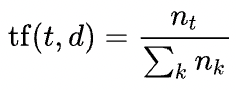
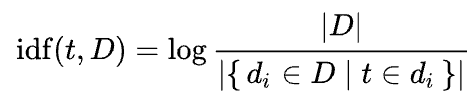
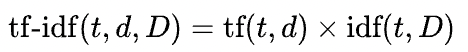

In [51]:
import math
example1 = 'в этом документе десять слов и одно из них заяц'.split()
example2 = 'а в этом такого слова нет'.split()
example3 = 'а здесь слова заяц снова есть есть заяц в этом документе'.split()

print('tf слова "заяц" в первом документе', example1.count('заяц')/len(example1))
print('tf слова "заяц" во втором документе', example2.count('заяц')/len(example2))
print('tf слова "заяц" во третьем документе', example3.count('заяц')/len(example3))

print('idf для слова заяц', math.log10(3/2))

print('tf*idf слова "заяц" в первом документе', example1.count('заяц')/len(example1) * math.log10(3/2))
print('tf*idf слова "заяц" во втором документе', example2.count('заяц')/len(example2) * math.log10(3/2))
print('tf*idf слова "заяц" во третьем документе', example3.count('заяц')/len(example3) * math.log10(3/2))

tf слова "заяц" в первом документе 0.1
tf слова "заяц" во втором документе 0.0
tf слова "заяц" во третьем документе 0.18181818181818182
idf для слова заяц 1.0
tf*idf слова "заяц" в первом документе 0.017609125905568124
tf*idf слова "заяц" во втором документе 0.0
tf*idf слова "заяц" во третьем документе 0.032016592555578406


In [55]:
print('tf*idf слова "заяц" в первом документе', example1.count('заяц')/len(example1) * math.log10(1000/2))
print('tf*idf слова "заяц" во втором документе', example2.count('заяц')/len(example2) * math.log10(1000/2))
print('tf*idf слова "заяц" во третьем документе', example3.count('заяц')/len(example3) * math.log10(1000/2))

tf*idf слова "заяц" в первом документе 0.2698970004336019
tf*idf слова "заяц" во втором документе 0.0
tf*idf слова "заяц" во третьем документе 0.49072181897018524


In [53]:
print('tf*idf слова "заяц" в первом документе', example1.count('заяц')/len(example1) * math.log10(1000/10))
print('tf*idf слова "заяц" во втором документе', example2.count('заяц')/len(example2) * math.log10(1000/10))
print('tf*idf слова "заяц" во третьем документе', example3.count('заяц')/len(example3) * math.log10(1000/10))

tf*idf слова "заяц" в первом документе 0.2
tf*idf слова "заяц" во втором документе 0.0
tf*idf слова "заяц" во третьем документе 0.36363636363636365


In [56]:
print('tf*idf слова "заяц" в первом документе', example1.count('заяц')/len(example1) * math.log10(1000/1000))
print('tf*idf слова "заяц" во втором документе', example2.count('заяц')/len(example2) * math.log10(1000/1000))
print('tf*idf слова "заяц" во третьем документе', example3.count('заяц')/len(example3) * math.log10(1000/1000))

tf*idf слова "заяц" в первом документе 0.0
tf*idf слова "заяц" во втором документе 0.0
tf*idf слова "заяц" во третьем документе 0.0


Используем Tfidvectorizer для конвертации данных в веса tfidf.

In [57]:
# Импортируем TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Инициализируем объект TfidfVectorizer: tfidf_vectorizer
# А также ограничили выдачу слов, которые мало встречаются в текстах, 
# использовав параметр max_df
tfidf_vectorizer = TfidfVectorizer(max_df = 0.7, min_df = 0.2) 
# Ограничиваем минимальный и максимальный порог встречаемости слова в текстах

Натренируем на тех же тестовых данных, что и CountVectorizer

In [58]:
# Тренируем классификатор
tfidf_train = tfidf_vectorizer.fit_transform(X_train['text'])
tfidf_test = tfidf_vectorizer.transform(X_test['text'])

Посмотрим что получили

In [59]:
# Выведем 10 первых признаков
print(tfidf_vectorizer.get_feature_names()[:5])

# Выведем первые 5 векторов обучающей выборки
print(tfidf_train.A[:5])


['10', '2016', 'about', 'according', 'after']
[[0.         0.         0.14443346 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.08832762 0.         0.        ]
 [0.         0.09497095 0.         ... 0.         0.07750256 0.22620801]
 [0.         0.         0.07640719 ... 0.         0.02931533 0.04278157]
 [0.         0.04410267 0.03126859 ... 0.         0.         0.        ]]


In [60]:
len(tfidf_vectorizer.get_feature_names()) # всего слов, удовлетворяющим нашим порогам было 212

209

Посмотрим, повлияет ли изменение метрики на качество алгоритма.

In [61]:
# Конвертируем получившиеся bag of words в массив Numpy

reg.fit(tfidf_train, y_train)
# Делаем предсказание логистической регрессией
result = reg.predict(tfidf_test)
accuracy_score(y_test, result)

0.860832137733142

Немного ухудшилось. Тут на самом деле играет роль то, что с данными в таком виде лучше работают другие алгоритмы, но это уже за пределами нашего курса.

### Confusion Matrix

Для более наглядного примера, мы можем построить Confusion Matrix. Диагональные элементы матрицы указывают на количество верных попаданий для данного класса (Fake или Real в нашем случае). Остальные элементы в строке показывают сколько новостей ушли в другой класс.

In [62]:
from sklearn import metrics
metrics.confusion_matrix(y_test, result)

array([[917, 154],
       [137, 883]])

142 фейковых новостей были некорректно отмечены как правдивые. И 173 реальных новостей были отмечены как фейковые.

Эта история важна, когда цена ошибки на одном из классов более высока. Например, наша алгоритм чаще называл фейковые новости реальными, чем наоборот. Если нам важно не назвать реальную новость фейковой, то мы ошиблись только 173 раз. А вот если наоборот, то цена ошибки выше.